## LiDAR ground truth generation for KITTI road evalution dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
import sys
sys.path.append('../')
from lidar_convenience import LidarTools
from kitti_road_lidar import kittiRoad
from helpers import display_stuff, scale_to_255

In [3]:
points_path = 'sample_data/umm_000015.bin'
calib_path  = 'sample_data/umm_000015.txt'
img_path    = 'sample_data/umm_000015.png'
gt_path     = 'sample_data/umm_road_000015.png'

In [4]:
points      = np.fromfile(points_path, dtype=np.float32).reshape(-1, 4)
calib_data  = kittiRoad().read_kitti_calib(calib_path)
img         = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
gt          = cv2.imread(gt_path, cv2.IMREAD_UNCHANGED)

In [5]:
def get_annotation(points, calib_data, gt, interpolation_fn=None):
    x, y, selector = kittiRoad().get_projection_mappings(points, calib_data, img, return_selector=True)

    gt_labels = (gt[:, :, 0]/ 255.0).astype(np.int)
    labels = np.zeros([points.shape[0], 1])
    labels[selector] = gt_labels[y, x].reshape(y.shape[0], 1)
    
    annotated_points = np.hstack([points, labels])
    if interpolation_fn is None:
        return annotated_points
    
    # creating dense annotation
    road_points = annotated_points[annotated_points[:,4]==1.][:, :4]
    new_road_points = []
    for i in range(0, road_points.shape[0]):
        _pseudo_point = interpolation_fn(road_points[i,:])
        new_road_points.append(_pseudo_point)
        
    new_road_points = np.vstack(new_road_points)
    _x, _y, _selector = kittiRoad().get_projection_mappings(new_road_points, calib_data, img, return_selector=True)

    _labels = np.zeros([new_road_points.shape[0], 1])
    _labels[_selector] = gt_labels[_y, _x].reshape(_y.shape[0], 1)
    _labels_mask = (_labels == 1).reshape(_labels.shape[0])
    new_road_points = new_road_points[_labels_mask]
    new_labels = np.ones([new_road_points.shape[0], 1])
    annotated_new_road_points = np.hstack([new_road_points, new_labels])
    return np.vstack([annotated_points, annotated_new_road_points])

In [6]:
def sector_interpolation(point, r, dr, dphi):
    new_points = []
    for phi_inc in np.arange(0, 360, dphi):
        rad_phi_inc = np.radians(phi_inc)
        for dr_inc in np.arange(dr, r, dr):
            _x = point[0] + dr_inc * np.cos(rad_phi_inc)
            _y = point[1] + dr_inc * np.sin(rad_phi_inc)
            new_points.append([_x, _y, point[2], point[3]])
    return np.array(new_points)#.astype(np.int64)

In [7]:
def get_lodnn_gt(points, calib_data, gt, filter_fn=None):
    '''
    Returns GT as two channels. Channel one will have GT points while channel one will have input points
    '''
    if filter_fn is not None:
        points = filter_fn(points)

    interpolation_method = lambda point : sector_interpolation(point, r=1, dr=0.2, dphi=10) #r=80, dr=1.5, dphi=2
    annotated_dense_points = get_annotation(points, calib_data, gt, interpolation_fn=interpolation_method)
     
    if filter_fn is not None:
        annotated_dense_points = filter_fn(annotated_dense_points)
    
    drivable_pixels = np.zeros(annotated_dense_points.shape[0])
    drivable_mask = annotated_dense_points[:,4] == 1
    drivable_pixels[drivable_mask] = 1
    channel_one = LidarTools().get_bev(points=annotated_dense_points, pixel_values=drivable_pixels)
    
    point_pixels = np.ones(points.shape[0])
    channel_two = LidarTools().get_bev(points=points, pixel_values=point_pixels)
    
    return np.dstack([channel_one, channel_two])

## Example

In [8]:
def get_pixel_color(points, min_distance=0, max_distance=120, is_annotated=True):
    '''
    Returns distance encoded pixel values and special color for road
    '''
    distance = np.sqrt(points[:, 0] ** 2 + points[:, 1] ** 2 + points[:, 2] ** 2)
    np.clip(distance, 0, max_distance, out=distance) 
    distance = (((distance - min_distance) / (max_distance - min_distance)) * 120).astype(np.uint8)
    if is_annotated:
        distance[points[:,4] == 1] = 120
    return distance

def get_rgb_img(height, width, y_img, x_img, pixel_values):
    '''
    converts gray to hsv to rgb
    '''
    hsv_ = cv2.cvtColor(np.zeros([height, width, 3], dtype=np.uint8), cv2.COLOR_RGB2HSV)
    
    hsv_[y_img, x_img, 0] = pixel_values
    hsv_[y_img, x_img, 1] = 255
    hsv_[y_img, x_img, 2] = 255
    
    return cv2.cvtColor(hsv_, cv2.COLOR_HSV2RGB)

In [9]:
lidar_tools = LidarTools()
bev_point_cloud = lidar_tools.get_bev(points=points,\
                         pixel_values=get_pixel_color(points, is_annotated=False),\
                         generate_img=get_rgb_img)

annotated_points = get_annotation(points, calib_data, gt)
bev_annotated_points = lidar_tools.get_bev(points=annotated_points,\
                         pixel_values=get_pixel_color(annotated_points),\
                         generate_img=get_rgb_img)

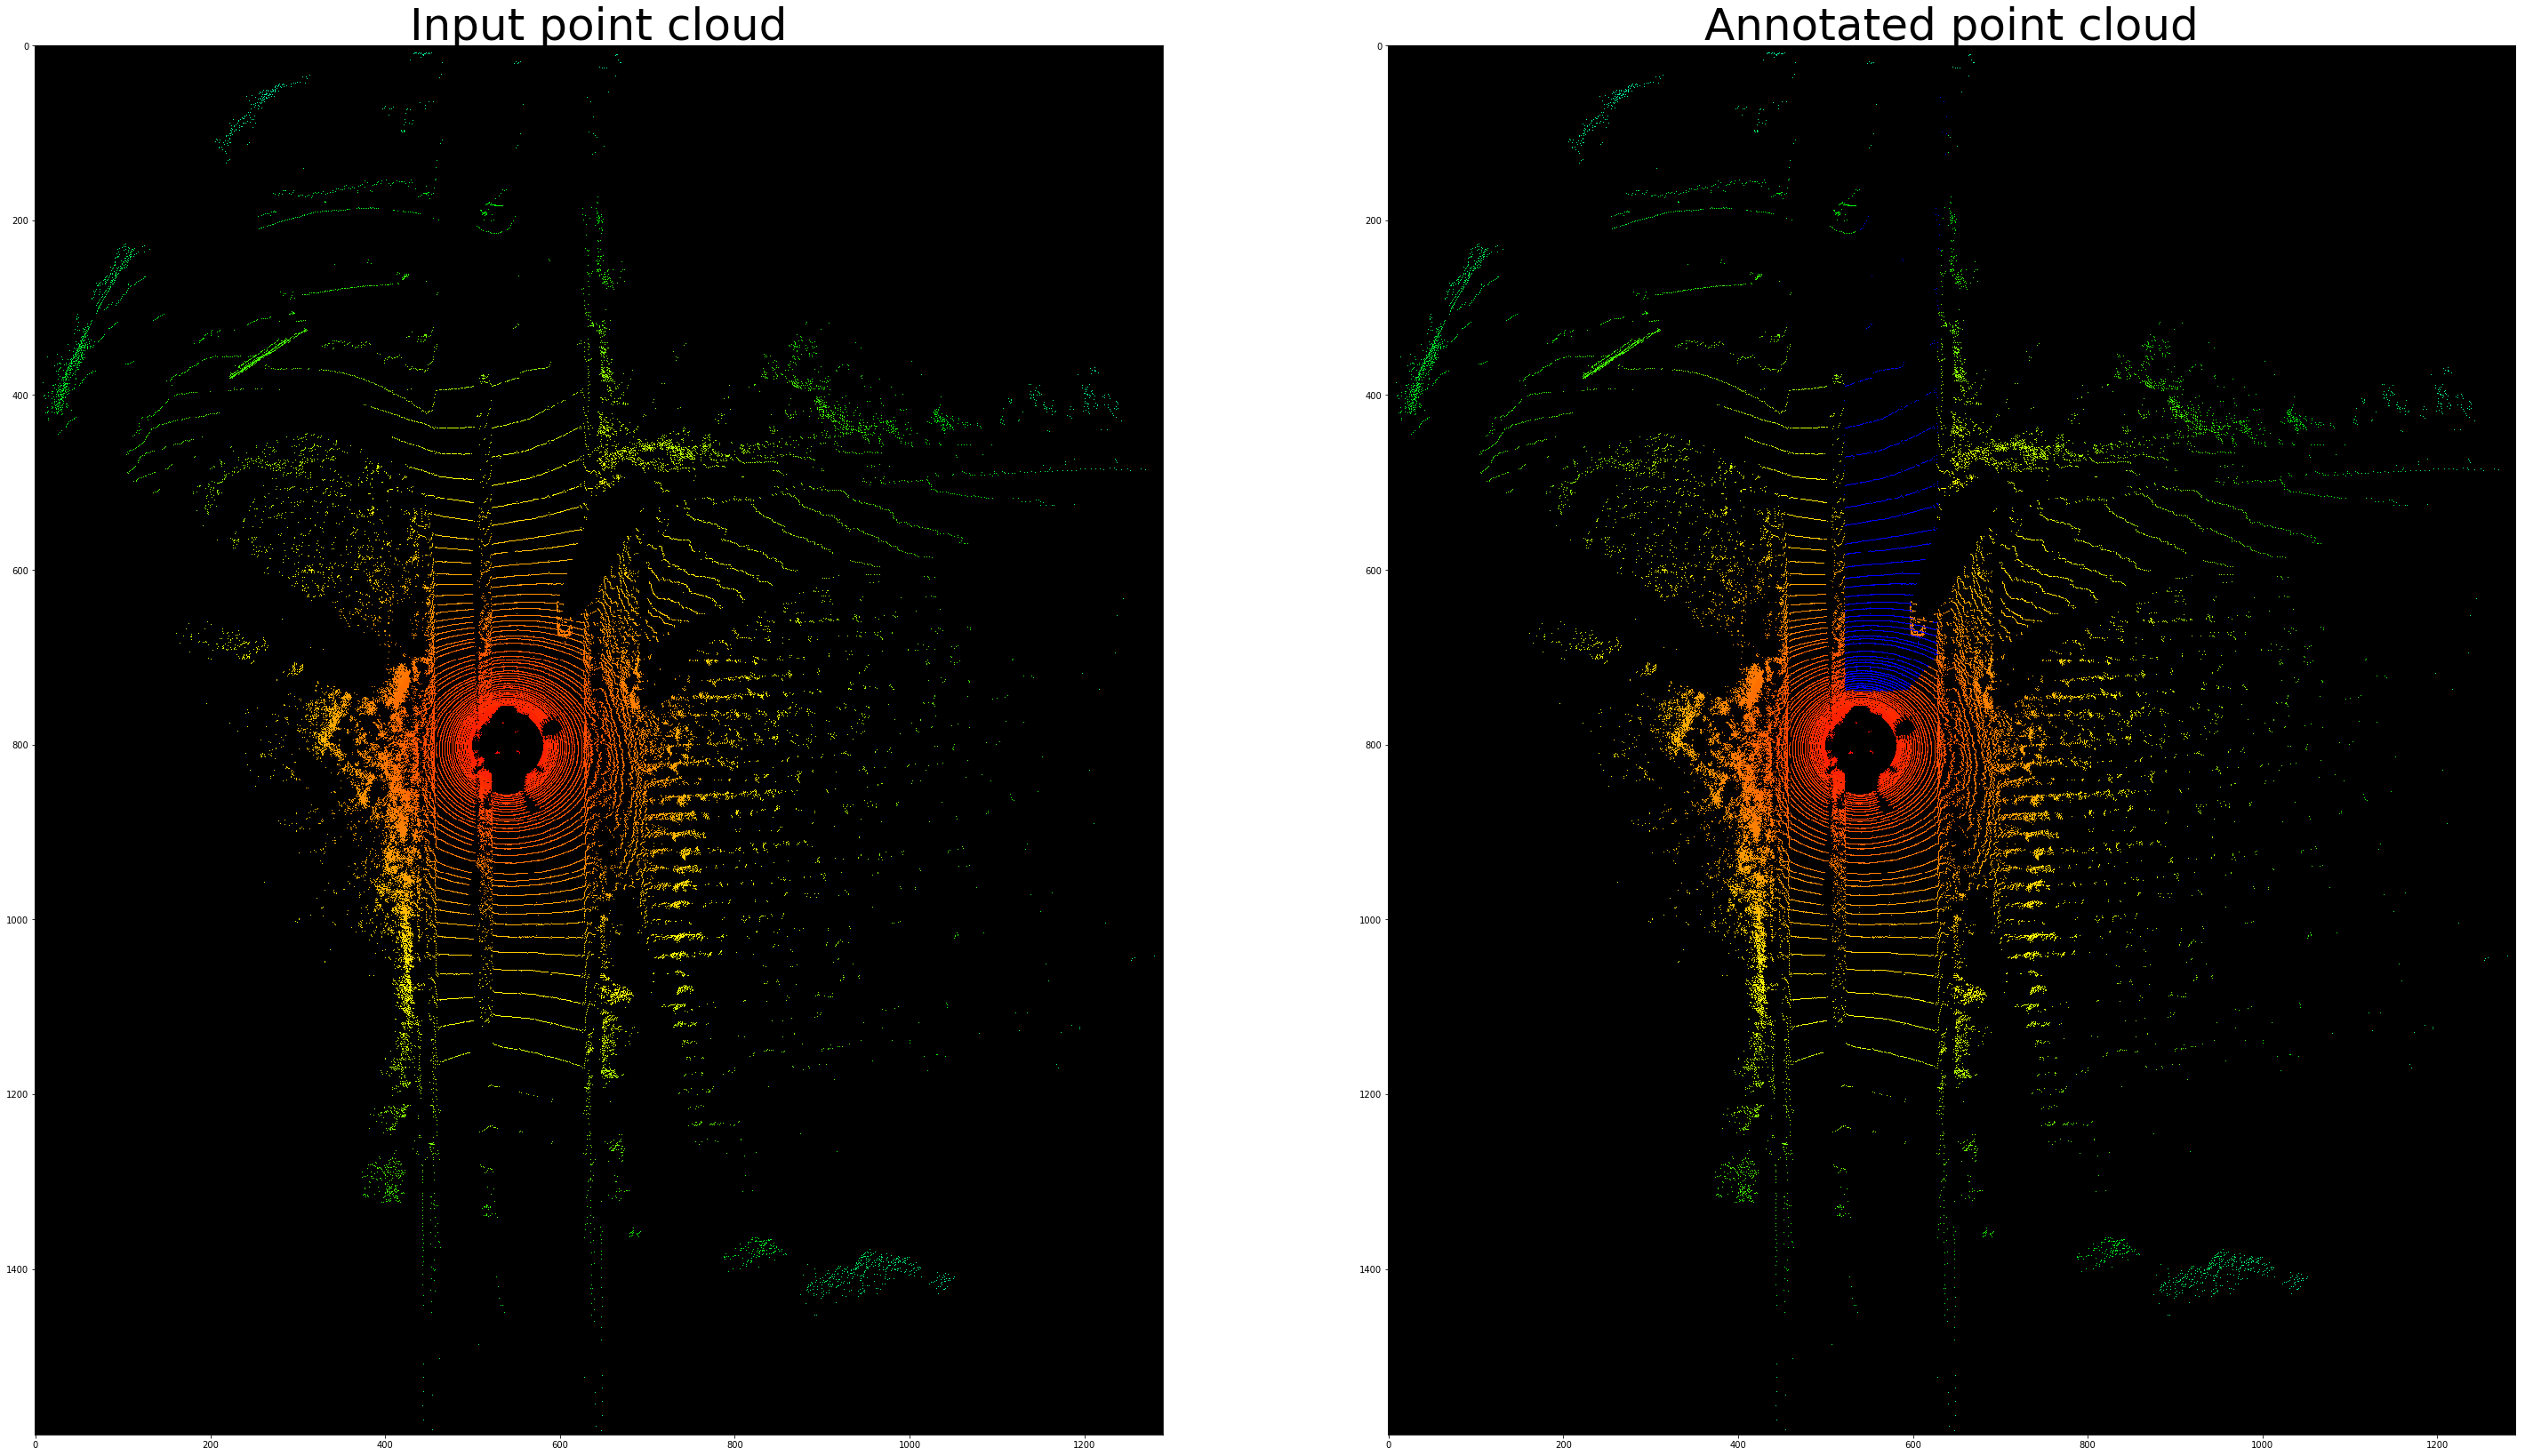

In [10]:
_ = display_stuff(imgs=[bev_point_cloud, bev_annotated_points],\
                  labels = ["Input point cloud", "Annotated point cloud"],\
                  figsize=(50, 50), fontsize=50)

In [11]:
interpolation_method = lambda point : sector_interpolation(point, r=1, dr=0.2, dphi=10) #r=80, dr=1.5, dphi=2

annotated_dense_points = get_annotation(points, calib_data, gt, interpolation_fn=interpolation_method)
bev_annotated_dense_points = lidar_tools.get_bev(points=annotated_dense_points,\
                         pixel_values=get_pixel_color(annotated_dense_points),\
                         generate_img=get_rgb_img)

filtered_points = LidarTools().filter_points(points, side_range=(-10, 10), fwd_range=(6, 46))
annotated_road_points = get_annotation(filtered_points, calib_data, gt, interpolation_fn=interpolation_method)
bev_annotated_road_points = lidar_tools.get_bev(points=annotated_road_points,\
                         pixel_values=get_pixel_color(annotated_road_points),\
                         generate_img=get_rgb_img)

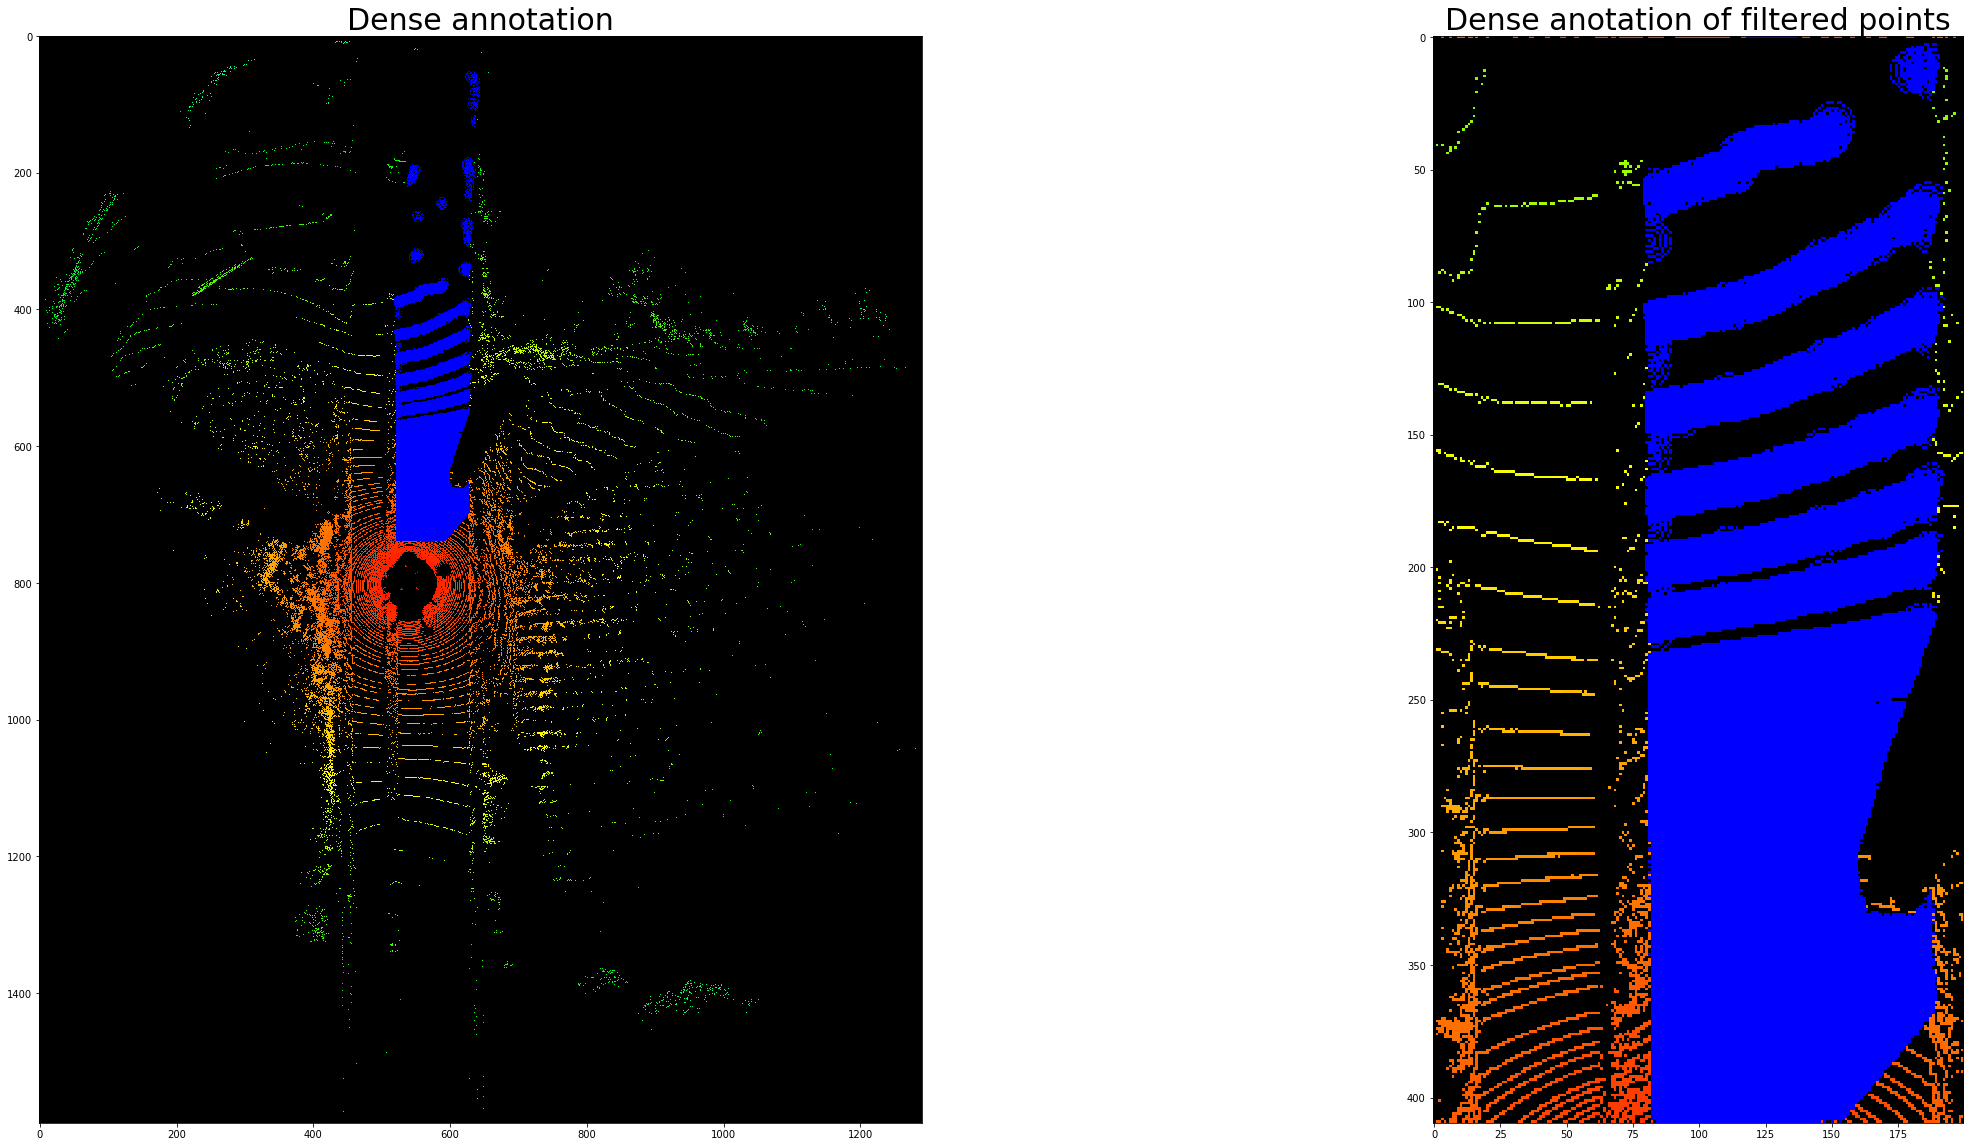

In [12]:
_ = display_stuff(imgs=[bev_annotated_dense_points, bev_annotated_road_points],\
                  labels = ["Dense annotation", "Dense anotation of filtered points"],\
                  figsize=(40, 20), fontsize=30)

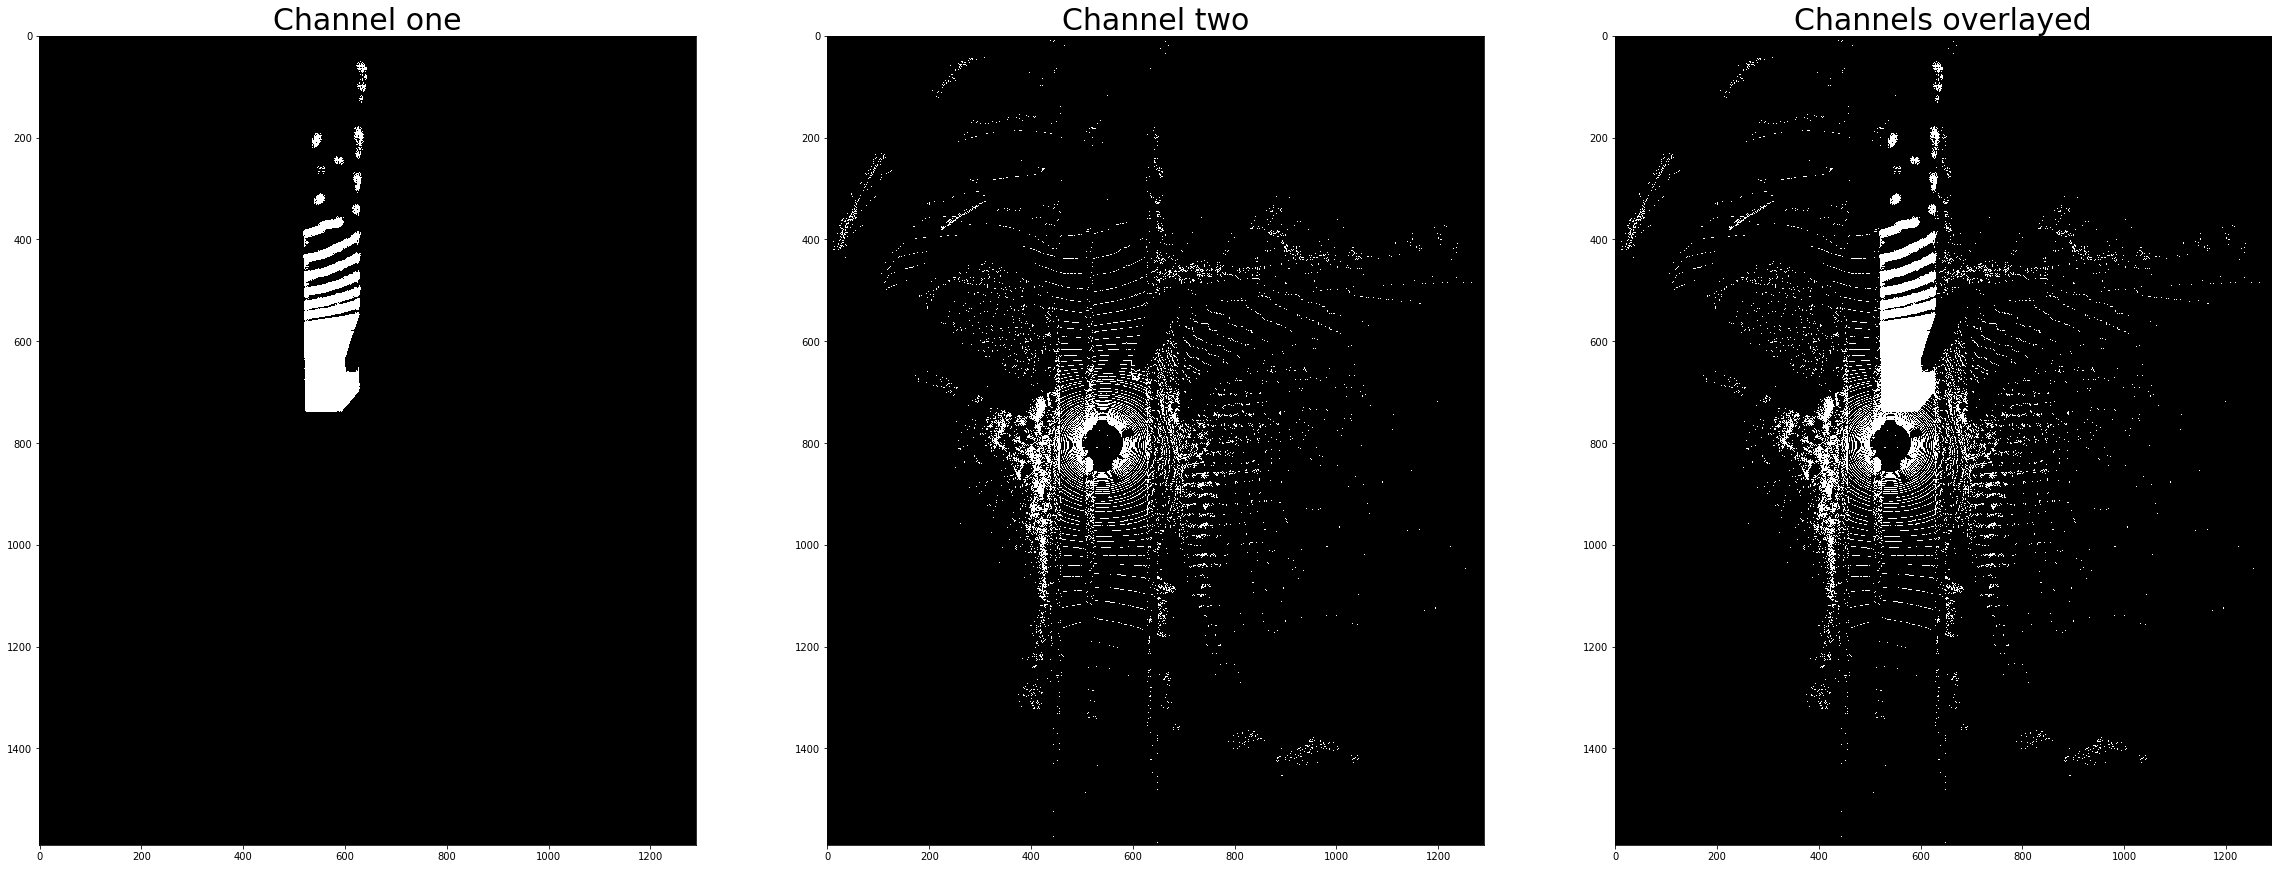

In [13]:
lodnn_gt = get_lodnn_gt(points, calib_data, gt)
overlayed_img = cv2.addWeighted(lodnn_gt[:, :, 0], 0.9, lodnn_gt[:, :, 1], 0.8, 0.8)

_ = display_stuff(imgs=[lodnn_gt[:, :, 0], lodnn_gt[:, :, 1], overlayed_img],\
                  labels = ["Channel one", "Channel two", "Channels overlayed"],\
                  figsize=(40, 40), fontsize=30, is_gray=True)

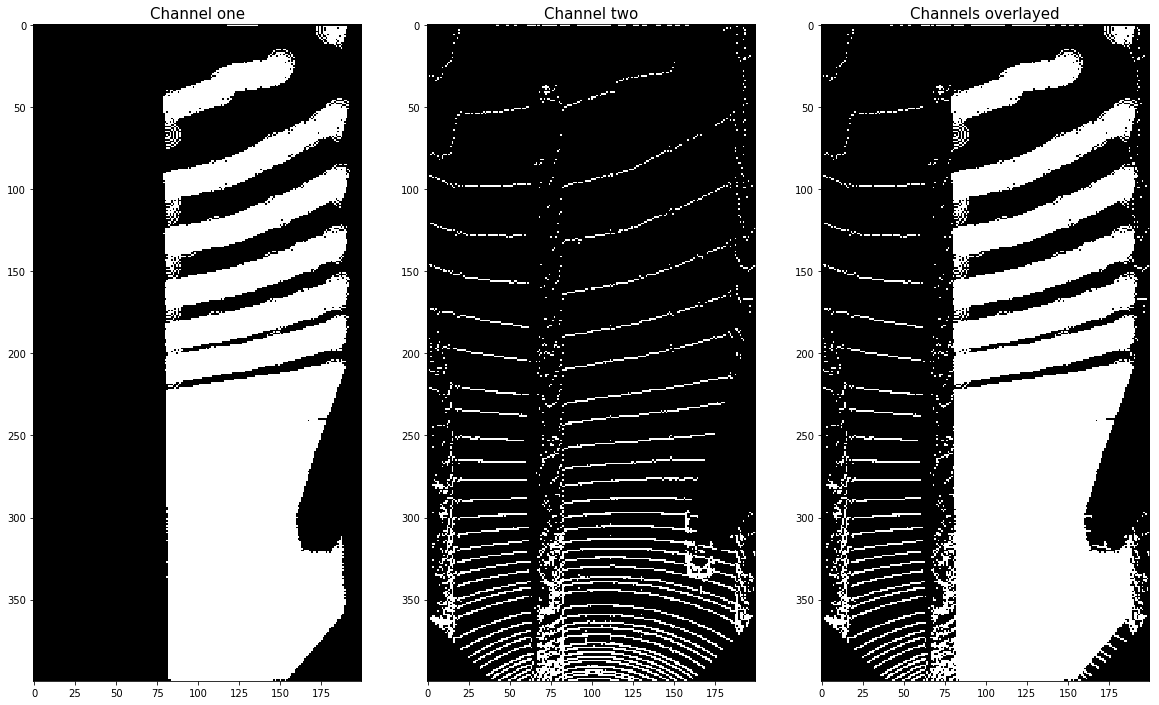

In [14]:
filter_fn = lambda points : LidarTools().filter_points(points, side_range=(-10, 10),\
                                                       fwd_range=(6, 46), horizontal_fov=(-45, 45))
lodnn_gt = get_lodnn_gt(filtered_points, calib_data, gt, filter_fn)

overlayed_img = cv2.addWeighted(lodnn_gt[:, :, 0], 0.9, lodnn_gt[:, :, 1], 0.8, 0.8)
_ = display_stuff(imgs=[lodnn_gt[:, :, 0], lodnn_gt[:, :, 1], overlayed_img],\
                  labels = ["Channel one", "Channel two", "Channels overlayed"],\
                  figsize=(20, 20), fontsize=15, is_gray=True)